<a href="https://colab.research.google.com/github/OdiaseJessica/RagPipeline/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jedi>=0.16


In [ ]:

!pip install -q llama-index llama-index-llms-gemini pymupdf
!pip install -q llama-index-embeddings-huggingface
!pip install nest_asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 14.5 MB/s eta 0:00:00


In [ ]:
import os
import fitz
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import nest_asyncio

nest_asyncio.apply()

GOOGLE_API_KEY = "AIza'''''''"
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY


!mkdir -p sample_docs

In [ ]:
from google.colab import files
import os

def upload_pdf():
    """Upload a PDF file and return its path."""
    print("Please select a PDF file to upload:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename.endswith('.pdf'):

            pdf_path = os.path.join("sample_docs", filename)


            os.makedirs("sample_docs", exist_ok=True)


            with open(pdf_path, 'wb') as f:
                f.write(uploaded[filename])

            print(f"PDF saved to {pdf_path}")
            return pdf_path
        else:
            print(f"File {filename} is not a PDF. Please upload a PDF file.")

    return None



In [ ]:
pdf_path = upload_pdf()

Please select a PDF file to upload:


Saving lenderform.pdf to lenderform.pdf
PDF saved to sample_docs/lenderform.pdf


In [ ]:
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file using PyMuPDF."""
    doc = fitz.open(pdf_path)


    text = "\n".join([page.get_text() for page in doc])


    print(f"PDF: {pdf_path}")
    print(f"Number of pages: {len(doc)}")
    print(f"Extracted {len(text.split())} words from the PDF.")


    doc.close()

    return text



In [ ]:
import fitz
pdf_path = "lenderform.pdf"
text = extract_text_from_pdf(pdf_path)


print(text[:500])


PDF: lenderform.pdf
Number of pages: 1
Extracted 404 words from the PDF.
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transac


In [ ]:
from llama_index.core import Document
from typing import List

def load_pdf_with_pymupdf(pdf_path: str) -> List[Document]:
    """Load a PDF and convert it to LlamaIndex Document format using PyMuPDF."""

    doc = fitz.open(pdf_path)


    documents = []

    for i, page in enumerate(doc):
        text = page.get_text()

        if not text.strip():
            continue

        documents.append(
            Document(
                text=text,
                metadata={
                    "file_name": os.path.basename(pdf_path),
                    "page_number": i + 1,
                    "total_pages": len(doc)
                }
            )
        )

    doc.close()


    print(f"Processed {pdf_path}:")
    print(f"Extracted {len(documents)} pages with content")

    return documents



In [ ]:

pdf_docs = load_pdf_with_pymupdf(pdf_path)

Processed lenderform.pdf:
Extracted 1 pages with content


In [ ]:
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

llm = Gemini(model="models/gemini-2.0-flash")
Settings.llm = llm


embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
Settings.embed_model = embed_model

def process_and_index_pdf(pdf_path):
    """Process a PDF and create both vector and keyword indices."""

    documents = load_pdf_with_pymupdf(pdf_path)


    vector_index = VectorStoreIndex.from_documents(documents)

    print(f"Indexed {len(documents)} document chunks")

    return vector_index



/tmp/ipython-input-509669980.py:6: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-2.0-flash")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

index = process_and_index_pdf(pdf_path)

Processed lenderform.pdf:
Extracted 1 pages with content
Indexed 1 document chunks


In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import QueryFusionRetriever


def create_query_expansion_engine(index):
    """Create a query engine that uses query expansion."""

    base_retriever = index.as_retriever(similarity_top_k=2)

    fusion_retriever = QueryFusionRetriever(
        retrievers=[base_retriever],
        llm=llm,
        similarity_top_k=2,
        num_queries=3,
        mode="reciprocal_rerank"
    )


    query_engine = RetrieverQueryEngine.from_args(
        retriever=fusion_retriever,
        llm=llm,
        verbose=True
    )

    return query_engine


In [ ]:

expanded_query_engine = create_query_expansion_engine(index)
response = expanded_query_engine.query("What are the penalties for late payments?")
print(response)

There is no information about penalties for late payments in the document.



In [ ]:
!pip install llama-index-retrievers-bm25

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.retrievers.bm25 import BM25Retriever

def create_hybrid_retriever(index, query, top_k=2):
    """Create a hybrid retrieval approach combining vector and keyword search."""

    vector_retriever = index.as_retriever(similarity_top_k=top_k)
    vector_nodes = vector_retriever.retrieve(query)

    nodes = [node for node in index.docstore.docs.values()]
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=top_k
    )
    keyword_nodes = bm25_retriever.retrieve(query)


    all_nodes = []
    all_nodes.extend(vector_nodes)
    all_nodes.extend(keyword_nodes)


    unique_nodes = []
    seen_ids = set()
    for node in all_nodes:
        if node.node_id not in seen_ids:
            unique_nodes.append(node)
            seen_ids.add(node.node_id)


    sorted_nodes = sorted(unique_nodes, key=lambda x: x.score if hasattr(x, 'score') else 0.0, reverse=True)

    top_nodes = sorted_nodes[:top_k]

    return top_nodes

In [ ]:

hybrid_nodes = create_hybrid_retriever(index, "What is the refund policy?")
for i, node in enumerate(hybrid_nodes):
    print(f"Result {i+1} (Score: {node.score:.4f}):")
    print(node.get_text())
    print("-" * 40)

DEBUG:bm25s:Building index from IDs objects


Result 1 (Score: 0.1802):
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount (-)
Principal & Interest
Other Financing (P & I)
Hazard

In [ ]:
def compare_retrieval_methods(index, query, top_k=2):
    """Compare different retrieval methods for the same query."""
    # Vector retrieval
    vector_retriever = index.as_retriever(similarity_top_k=top_k)
    vector_nodes = vector_retriever.retrieve(query)

    # Keyword retrieval (BM25)
    nodes = [node for node in index.docstore.docs.values()]
    keyword_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=top_k
    )
    keyword_nodes = keyword_retriever.retrieve(query)


    hybrid_nodes = create_hybrid_retriever(index, query, top_k)

    results = []

    for method, nodes in [
        ("Vector (Semantic)", vector_nodes),
        ("Keyword (BM25)", keyword_nodes),
        ("Hybrid", hybrid_nodes)
    ]:
        for i, node in enumerate(nodes):
            results.append({
                "Method": method,
                "Rank": i + 1,
                "Score": node.score if hasattr(node, 'score') else 0.0,
                "Content": node.get_text()[:200] + "...",
                "Page": node.metadata.get("page_number", "Unknown") if hasattr(node, 'metadata') else "Unknown"
            })

    results_df = pd.DataFrame(results)
    display(results_df)

    plt.figure(figsize=(10, 6))
    for method in ["Vector (Semantic)", "Keyword (BM25)", "Hybrid"]:
        method_df = results_df[results_df["Method"] == method]
        plt.bar(
            [f"{method} - Rank {row['Rank']}" for _, row in method_df.iterrows()],
            method_df["Score"],
            alpha=0.7,
            label=method
        )

    plt.xlabel("Result")
    plt.ylabel("Retrieval Score")
    plt.title(f"Comparison of Retrieval Methods for Query: '{query}'")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df

DEBUG:bm25s:Building index from IDs objects
DEBUG:bm25s:Building index from IDs objects


,Method,Rank,Score,Content,Page
0,Vector (Semantic),1,0.18017,"Your actual rate, payment, and cost could be h...",1
1,Keyword (BM25),1,0.00000,"Your actual rate, payment, and cost could be h...",1
2,Hybrid,1,0.18017,"Your actual rate, payment, and cost could be h...",1


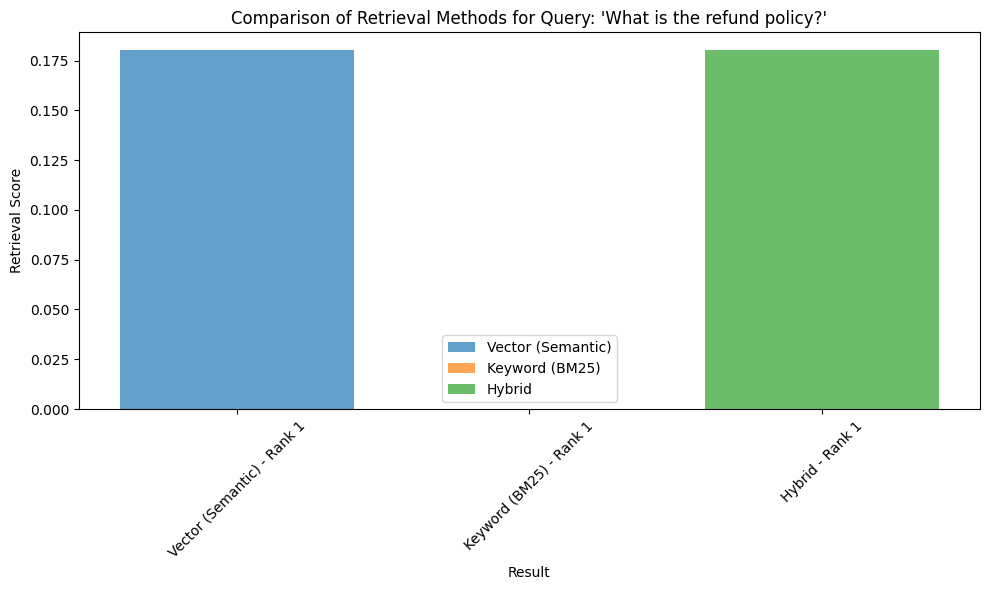

In [ ]:

comparison = compare_retrieval_methods(index, "What is the refund policy?")

In [ ]:
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.core.schema import NodeWithScore

# Create a reranker
def rerank_results(nodes, query, top_n=2):
    """Rerank retrieved nodes using the Sentence Transformer reranker."""
    # Create the reranker
    reranker = SentenceTransformerRerank(
        model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        top_n=top_n
    )

    # Rerank the nodes
    reranked_nodes = reranker.postprocess_nodes(
        nodes,
        query_str=query
    )

    return reranked_nodes

# Function to demonstrate the reranking process
def demonstrate_reranking(index, query, top_k=4):
    """Demonstrate the reranking process on retrieval results."""
    # First retrieve more nodes than we need
    retriever = index.as_retriever(similarity_top_k=top_k)
    nodes = retriever.retrieve(query)

    print(f"Query: {query}")
    print("\nOriginal Retrieval Order:")
    for i, node in enumerate(nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Now rerank them
    reranked_nodes = rerank_results(nodes, query, top_n=2)

    print("\nAfter Reranking:")
    for i, node in enumerate(reranked_nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Create comparison dataframe
    results = []

    # Original ranking
    for i, node in enumerate(nodes):
        results.append({
            "Stage": "Original Retrieval",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    # Reranked
    for i, node in enumerate(reranked_nodes):
        results.append({
            "Stage": "After Reranking",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    results_df = pd.DataFrame(results)
    display(results_df)

    return results_df

# Example usage:
reranking_demo = demonstrate_reranking(index, "What happens if I cancel the service?", top_k=4)

Query: What happens if I cancel the service?

Original Retrieval Order:
1. (Score: 0.0416) - Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


After Reranking:
1. (Score: -10.9593) - Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a...


,Stage,Rank,Score,Content,Page
0,Original Retrieval,1,-10.959277,"Your actual rate, payment, and cost could be h...",1
1,After Reranking,1,-10.959277,"Your actual rate, payment, and cost could be h...",1


In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle

def build_rag_pipeline(index):
    """Build a simple but effective RAG pipeline with hybrid retrieval and reranking."""

    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())

    # Determine safe top_k value (number of nodes to retrieve)
    # Must be at least 1 and no more than the number of available nodes
    num_nodes = len(nodes)
    safe_top_k = min(2, max(1, num_nodes))

    print(f"Index contains {num_nodes} nodes, using top_k={safe_top_k}")

    # Step 1: Create a hybrid retriever combining vector and keyword search
    # First, get the vector retriever (for semantic understanding)
    vector_retriever = index.as_retriever(
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Next, create a BM25 retriever (for keyword matching)
    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Create a proper hybrid retriever class
    class HybridRetriever(BaseRetriever):
        """Hybrid retriever that combines vector and keyword search results."""

        def __init__(self, vector_retriever, keyword_retriever, top_k=2):
            """Initialize with vector and keyword retrievers."""
            self.vector_retriever = vector_retriever
            self.keyword_retriever = keyword_retriever
            self.top_k = top_k
            super().__init__()

        def _retrieve(self, query_bundle, **kwargs):
            """Retrieve from both retrievers and combine results."""
            # Get results from both retrievers
            vector_nodes = self.vector_retriever.retrieve(query_bundle)
            keyword_nodes = self.keyword_retriever.retrieve(query_bundle)

            # Combine all nodes
            all_nodes = list(vector_nodes) + list(keyword_nodes)

            # Remove duplicates (by node_id)
            unique_nodes = {}
            for node in all_nodes:
                if node.node_id not in unique_nodes:
                    unique_nodes[node.node_id] = node

            # Sort by score (higher is better)
            sorted_nodes = sorted(
                unique_nodes.values(),
                key=lambda x: x.score if hasattr(x, 'score') else 0.0,
                reverse=True
            )

            return sorted_nodes[:self.top_k]  # Return top results

    # Create our hybrid retriever instance
    hybrid_retriever = HybridRetriever(
        vector_retriever=vector_retriever,
        keyword_retriever=bm25_retriever,
        top_k=safe_top_k
    )

    # Step 2: Create a reranker to prioritize the most relevant chunks
    if num_nodes > 1:
        reranker = SentenceTransformerRerank(
            model="cross-encoder/ms-marco-MiniLM-L-6-v2",
            top_n=min(2, num_nodes)  # Keep only top results after reranking
        )
        node_postprocessors = [reranker]
    else:
        node_postprocessors = []


    # Step 3: Build the query engine
    query_engine = RetrieverQueryEngine.from_args(
        retriever=hybrid_retriever,
        llm=llm,
        node_postprocessors=[reranker]
    )

    return query_engine

In [ ]:
# option 2 (your query-expansion engine)
response = expanded_query_engine.query("How much does the borrower pay for lender's title insurance?")
print(response)


The borrower pays $650.00 for lender's title insurance.



In [ ]:

response = expanded_query_engine.query("What is the total estimated monthly payment?")
print(response)



The total estimated monthly payment is $2,308.95.



In [ ]:
!pip install -q llama-index llama-index-embeddings-huggingface
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.gemini import Gemini
llm = Gemini(model="models/gemini-2.0-flash")


/tmp/ipython-input-830796833.py:4: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-2.0-flash")


In [ ]:

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Default (example) embedding model
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
index = VectorStoreIndex.from_documents(pdf_docs, embed_model=embed_model)


In [ ]:
!pip install -q llama-index llama-index-embeddings-huggingface

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.core import VectorStoreIndex

llm = Gemini(model="models/gemini-2.0-flash")
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

index = VectorStoreIndex.from_documents(pdf_docs, embed_model=embed_model)


/tmp/ipython-input-1183233344.py:7: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-2.0-flash")


In [ ]:
embed_model = HuggingFaceEmbedding(model_name="intfloat/e5-small-v2")


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [ ]:
[name for name in ["rag_engine","expanded_query_engine","query_engine","index"] if name in globals()]


['expanded_query_engine', 'index']

In [ ]:
query = "What is the maximum loan amount a borrower can apply for?"
response = expanded_query_engine.query(query)
print(response)


The maximum loan amount a borrower can apply for is $380,000.



In [ ]:
retrieved_nodes = expanded_query_engine.retriever.retrieve("What is the maximum loan amount a borrower can apply for?")
for node in retrieved_nodes:
    print("-" * 80)
    print(node.get_text())


--------------------------------------------------------------------------------
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount 

In [ ]:
retriever = index.as_retriever(similarity_top_k=2)
retrieved_nodes = retriever.retrieve("What is the maximum loan amount a borrower can apply for?")
for node in retrieved_nodes:
    print("-" * 80)
    print(node.get_text())


--------------------------------------------------------------------------------
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount 

In [ ]:

retrieved_nodes = retriever.retrieve(query)
for node in retrieved_nodes:
    print("-" * 80)
    print(node.get_text())

--------------------------------------------------------------------------------
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount 

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [ ]:
query = "What is the maximum loan amount a borrower can apply for?"

In [ ]:
for node in retriever.retrieve(query):
    print(node.get_text())

Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount (-)
Principal & Interest
Other Financing (P & I)
Hazard Insurance
Real Estate Tax

In [ ]:

# BGE-small
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
query = "What is the maximum loan amount a borrower can apply for?"

for node in retriever.retrieve(query):
    print(node.get_text())


Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount (-)
Principal & Interest
Other Financing (P & I)
Hazard Insurance
Real Estate Tax

In [ ]:
embed_model = HuggingFaceEmbedding(model_name="intfloat/e5-small-v2")



In [ ]:
query = "What is the maximum loan amount a borrower can apply for?"

for node in retriever.retrieve(query):
    print(node.get_text())


Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount (-)
Principal & Interest
Other Financing (P & I)
Hazard Insurance
Real Estate Tax

In [ ]:
for node in retriever.retrieve(query):
    print(node.get_text())


Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount (-)
Principal & Interest
Other Financing (P & I)
Hazard Insurance
Real Estate Tax

In [ ]:
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.core.response_synthesizers import get_response_synthesizer
import pandas as pd

def run_rag_test(index, llm, query, top_k=5, threshold=None, rerank=False):
    retriever = index.as_retriever(similarity_top_k=top_k)
    nodes = retriever.retrieve(query)

    # Filter out weak matches if a threshold is given
    if threshold:
        nodes = [n for n in nodes if n.score and n.score > threshold]

    # Rerank the results if enabled
    if rerank:
        reranker = SentenceTransformerRerank(model="cross-encoder/ms-marco-MiniLM-L-6-v2", top_n=len(nodes))
        nodes = reranker.postprocess_nodes(nodes, query_str=query)

    # Generate an answer based only on these nodes
    synth = get_response_synthesizer(response_mode="compact", llm=llm)
    answer = synth.synthesize(query=query, nodes=nodes)

    # Show chunks
    print(f"\n🔸 top_k={top_k}, threshold={threshold}, rerank={rerank}")
    for i, node in enumerate(nodes):
        print(f"\nChunk {i+1} (Score: {node.score:.2f})\n{node.get_text()[:300]}...")
    print("\nAnswer:\n", answer, "\n")

    return {
        "top_k": top_k,
        "threshold": threshold,
        "rerank": rerank,
        "chunks": len(nodes),
        "answer": str(answer)[:250] + "...",
    }


In [ ]:
query = "What is the maximum loan amount a borrower can apply for?"

results = []
results.append(run_rag_test(index, llm, query, top_k=5, threshold=None, rerank=False))   # A
results.append(run_rag_test(index, llm, query, top_k=8, threshold=0.75, rerank=False))   # B
results.append(run_rag_test(index, llm, query, top_k=5, threshold=0.75, rerank=True))    # C

pd.DataFrame(results)



🔸 top_k=5, threshold=None, rerank=False

Chunk 1 (Score: 0.48)
Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purpos...

Answer:
 The maximum loan amount a borrower can apply for is $380,000.
 


🔸 top_k=8, threshold=0.75, rerank=False

Answer:
 Empty Response 


🔸 top_k=5, threshold=0.75, rerank=True

Answer:
 Empty Response 



,top_k,threshold,rerank,chunks,answer
0,5,NaN,False,1,The maximum loan amount a borrower can apply f...
1,8,0.75,False,0,Empty Response...
2,5,0.75,True,0,Empty Response...


In [ ]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Any
import pandas as pd
import textwrap


def _excerpt(t, n=200):
    t = (t or "").strip().replace("\n"," ")
    return t[:n] + ("…" if len(t)>n else "")

def _apply_threshold(nodes: List[NodeWithScore], thr: Optional[float]):
    if thr is None:
        return nodes
    return [n for n in nodes if getattr(n, "score", None) is not None and n.score >= thr]

@dataclass
class RAGCfg:
    name: str
    top_k: int
    threshold: Optional[float]
    rerank: bool

def run_cfg(index, llm, query: str, cfg: RAGCfg) -> Dict[str, Any]:
    retriever = index.as_retriever(similarity_top_k=cfg.top_k)
    nodes = retriever.retrieve(query)
    nodes = _apply_threshold(nodes, cfg.threshold)

    if cfg.rerank and len(nodes) > 1:
        reranker = SentenceTransformerRerank(model="cross-encoder/ms-marco-MiniLM-L-6-v2",
                                             top_n=min(len(nodes), cfg.top_k))
        nodes = reranker.postprocess_nodes(nodes, query_str=query)

    synth = get_response_synthesizer(response_mode="compact", llm=llm)
    answer = synth.synthesize(query=query, nodes=nodes)
    answer_text = str(answer)

    print(f"\n=== {cfg.name} | top_k={cfg.top_k} | threshold={cfg.threshold} | reranker={'ON' if cfg.rerank else 'OFF'} ===")
    if not nodes:
        print("(No chunks after filtering.)")
    for i, n in enumerate(nodes, 1):
        s = getattr(n, "score", float("nan"))
        print(f"\nChunk {i} (Score: {s:.2f})\n{textwrap.indent(_excerpt(n.get_text(), 600), '  ')}")

    return {
        "Config": cfg.name,
        "Chunks Retrieved": len(nodes),
        "Best Chunk (short excerpt)": _excerpt(nodes[0].get_text()) if nodes else "",
        "Answer (shortened)": _excerpt(answer_text, 300),
        "Confidence (1–5)": None,  # fill after you read outputs
        "Notes": ""                # fill after you read outputs
    }

# ---- set your question here ----
query = "What is the maximum loan amount a borrower can apply for?"

configs = [
    RAGCfg("A (Default)",      top_k=5, threshold=None,   rerank=False),
    RAGCfg("B (Filter 0.75)",  top_k=8, threshold=0.75,   rerank=False),
    RAGCfg("C (Rerank + 0.75)",top_k=5, threshold=0.75,   rerank=True),
]

rows = [run_cfg(index, llm, query, cfg) for cfg in configs]
df = pd.DataFrame(rows, columns=[
    "Config","Chunks Retrieved","Best Chunk (short excerpt)",
    "Answer (shortened)","Confidence (1–5)","Notes"
])
df



=== A (Default) | top_k=5 | threshold=None | reranker=OFF ===

Chunk 1 (Score: 0.48)
  Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan. Fee Details and Summary Applicants: Application No: Date Prepared: Loan Program: Prepared By: THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage  payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed. Total Loan Amount:   Interest Rate: Term/Due In: F…

=== B (Filter 0.75) | top_k=8 | threshold=0.75 | reranker=OFF ===
(No chunks after filtering.)

=== C (Rerank + 0.75) | top_k=5 | threshold=0.75 | reranker=ON ===
(No chunks after filtering.)


,Config,Chunks Retrieved,Best Chunk (short excerpt),Answer (shortened),Confidence (1–5),Notes
0,A (Default),1,"Your actual rate, payment, and cost could be h...",The maximum loan amount a borrower can apply f...,None,
1,B (Filter 0.75),0,,Empty Response,None,
2,C (Rerank + 0.75),0,,Empty Response,None,
